Resnet50 model to implement for the FeelBeat Project

In [ ]:
!pip install Keras-Applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00


In [ ]:
!pip install scikit-image
!pip install pydot

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

In [ ]:
%matplotlib inline
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from sklearn.metrics import *
from tensorflow.keras.models import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize
from tensorflow.keras.applications import ResNet50

import pydot


In [ ]:
EPOCHS = 100
BS = 64
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 170

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 197

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/train.zip' -d train
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/ck_train.zip' -d train
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/ck+_train.zip' -d train
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/train_jaffe.zip' -d train







In [ ]:
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/test-public.zip' -d dev
! rm -rf test; mkdir test
! unzip -q '/content/drive/MyDrive/CSE499A/Datasets/test-private.zip' -d test


In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            preprocessing_function=preprocess_input,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(preprocessing_function=preprocess_input,)

    return datagen.flow_from_directory(
            dataset,
            target_size=(197, 197),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [ ]:
train_generator = get_datagen('/content/train',True)
dev_generator = get_datagen('/content/dev')
test_generator =get_datagen('/content/test')

Found 30533 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
# Load the ResNet50 model
resnet50_notop = ResNet50(include_top=False, weights='imagenet', input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')

# Get the output from the last layer
last_layer = resnet50_notop.output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)

# Adjusting for the number of layers in ResNet50 for freezing.
# Keep in mind that the indices for BatchNorm layers in the original code might be specific to VGGFace's ResNet50 variant.
# You'd need to adjust these indices for the standard ResNet50 if necessary.
batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167]
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:  # If you've specific indices for batch norm layers.
        resnet50_notop.layers[i].trainable = False

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(resnet50_notop.input, out)
initial_learning_rate_optim = ADAM_LEARNING_RATE

learning_rate_schedule_optim = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_optim,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optim = keras.optimizers.Adam(learning_rate=learning_rate_schedule_optim, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

initial_learning_rate = SGD_LEARNING_RATE
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=SGD_DECAY,
    staircase=True)

sgd = tf.keras.optimizers.SGD(learning_rate=learning_rate_schedule, momentum=0.9, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=10, min_lr=0.00001, verbose=1)
callbacks_list = [rlrop]

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
history = model.fit(
    x=train_generator,
    validation_data=dev_generator,
    shuffle=True,
    steps_per_epoch = 28709//BS,
    validation_steps = 3589//BS,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    use_multiprocessing=True
)

Epoch 1/100
448/448 [==============================] - 304s 662ms/step - loss: 1.7095 - accuracy: 0.3103 - val_loss: 1.4011 - val_accuracy: 0.4621 - lr: 0.0100
Epoch 2/100
448/448 [==============================] - 298s 664ms/step - loss: 1.3896 - accuracy: 0.4705 - val_loss: 1.4007 - val_accuracy: 0.4833 - lr: 0.0100
Epoch 3/100
448/448 [==============================] - 303s 675ms/step - loss: 1.2614 - accuracy: 0.5181 - val_loss: 1.3136 - val_accuracy: 0.5039 - lr: 0.0100
Epoch 4/100
448/448 [==============================] - 292s 651ms/step - loss: 1.1858 - accuracy: 0.5509 - val_loss: 1.1277 - val_accuracy: 0.5642 - lr: 0.0100
Epoch 5/100
448/448 [==============================] - 291s 649ms/step - loss: 1.1396 - accuracy: 0.5680 - val_loss: 1.1845 - val_accuracy: 0.5536 - lr: 0.0100
Epoch 6/100
448/448 [==============================] - 286s 638ms/step - loss: 1.1069 - accuracy: 0.5844 - val_loss: 1.2538 - val_accuracy: 0.5307 - lr: 0.0100
Epoch 7/100
448/448 [===================

In [ ]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 3509 // BS)
print('Test loss, Test acc: ',results_test)



# Evaluate on test data


<ipython-input-32-370b98cc6c28>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results_test = model.evaluate_generator(test_generator, 3509 // BS)


Test loss, Test acc:  [0.9147941470146179, 0.6791087985038757]


In [ ]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate_generator(dev_generator, 3509 // BS)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data


<ipython-input-33-5b76f0701e1a>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results_dev = model.evaluate_generator(dev_generator, 3509 // BS)


dev loss, dev acc: [0.9743040800094604, 0.6736111044883728]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


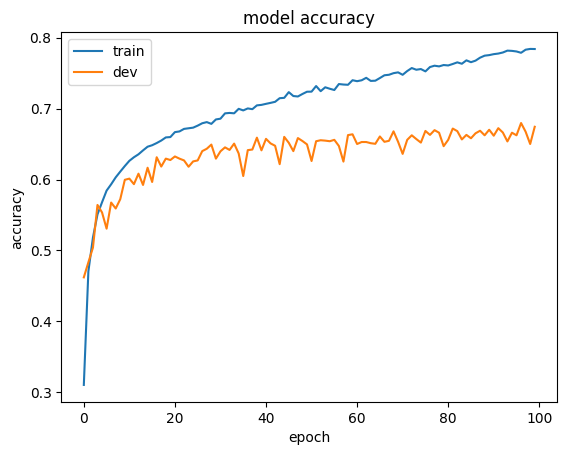

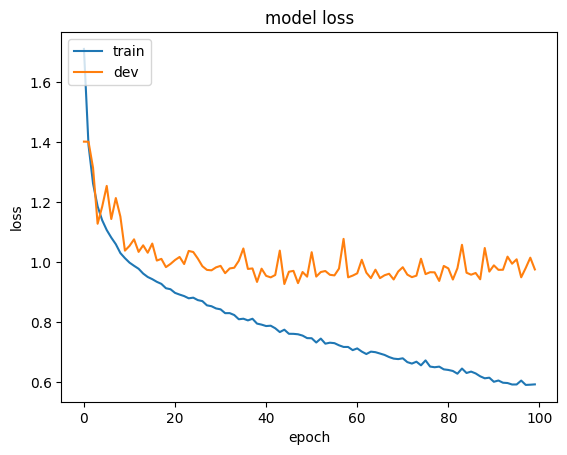

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/CSE499A/models' + 'RESNET50' + epoch_str + test_acc + '.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button").click()
}setInterval(ClickConnect,600000)